# Example pos Experiment

Please note that this experiment requires a pos testbed as well as a **pos-enabled Python3 kernel**.  See, e.g., [`README.ipynb`](README.ipynb) for information on how to obtain them.

In [1]:
import json
import io
import types
import pathlib

In [2]:
# poslib calls `setfacl` which isn't installed here, so we fake any subprocess calls
import subprocess
def noop_call(*args, **kwargs):
    pass
subprocess.call = noop_call

In [3]:
# our local username isn't the one in the testbed, so we fake it
import getpass
getpass.getuser = lambda: "debian"

In [4]:
import IPython.display

In [5]:
try:
    import poslib.api as pos
    import poslib.restapi
except ModuleNotFoundError as error:
    raise UserWarning("Please use a pos-enabled kernel!") from error

In [6]:
try:
    pos.nodes.list_all()
except Exception as error:
    raise UserWarning("Unable to communicate with pos, please double check the setup") from error

Define variables used throughout this experiment.  Note that some variables are hardware-specific and this loaded from the previously generated `variables.json`.

In [7]:
with pathlib.Path("variables.json").open("tr", encoding="utf8") as variables:
    TESTBED_SPECIFIC = json.load(variables)

In [8]:
NODES = {"dut": "experiment-1", "loadgen": "experiment-2", "evaluator": "experiment-1"}

The following cell specifies the global variables. These variables are shared across all experiment nodes participating in an experiment.

In [9]:
GLOBAL_VARS = {**{
    "moongen_repo": "https://github.com/gallenmu/MoonGen",
    "moongen_repo_commit": "21641c9c3432fa8a5f93b135cf38b5247750d0a0",
    "moongen_dir": "/root/moongen",
    
    "loadgen_ingress_dev": 1,
    "loadgen_egress_dev": 0,
    "loadgen_ingress_if": "ens4",
    "loadgen_egress_if": "ens5",
    "loadgen_ingress_mac": "52:54:00:78:0a:23",
    "loadgen_egress_mac": "52:54:00:78:0a:20",
    "loadgen_ingress_ip": "10.0.0.20",
    "loadgen_egress_ip": "10.0.1.23",
    "loadgen_enable_ip_sw_chksum_calc": 1,
    "loadgen_enable_offload": 0,
    
    "dut_ingress_if": "ens4",
    "dut_egress_if": "ens5",
    "dut_ingress_mac": "52:54:00:80:0a:22",
    "dut_egress_mac": "52:54:00:80:0a:21",
    "dut_ingress_ip": "10.0.1.22",
    "dut_egress_ip": "10.0.0.21",
}, **TESTBED_SPECIFIC.get("global", {})}

The following cell specify the local variables. These variables are exclusive for a specific experiment node.

Typically, a seperate local variable file for each participating experiment node is created.

In [10]:
LOCAL_VARS = {
    "dut": {
    },
    "loadgen": {
        "ingress": 0,
        "egress": 1,
        
        "warm_up": 0,
    },
}

The following cell specifies the loop variables. These variables parameterize the task that describes the actual experiment. A typical parameter to investigate in networked experiments would be different packet rates and packet sizes.

In [11]:
LOOP_VARS = {**{
    "pkt_rate": [10000, 20000, "...", 300000],
    "pkt_sz": [64, 1450],
}, **TESTBED_SPECIFIC.get("loop", {})}

Freeing of experiment nodes (if nodes were not freed during previous experiment)

In [12]:
for node in NODES.values():
    pos.allocations.free(node)

Create a new allocation for this experiment.

In [13]:
ALLOCATION, _, RESULTS_PATH = pos.allocations.allocate(NODES.values(), result_folder="oppos", duration=60)

Group nodes in a combined role.

In [14]:
ALL = "all"
try:
    pos.roles.delete(ALL)
except poslib.restapi.HTTPNotFound:
    pass  # the role shouldn't be present on the first run (unless it was created in another experiment)
pos.roles.add(ALL, list(set(NODES.values())))

In [15]:
pos.allocations.set_variables(next(iter(NODES.values())), io.StringIO(json.dumps(GLOBAL_VARS)), "json", as_global=True, as_loop=False, print_variables=False)

In [16]:
pos.allocations.set_variables(next(iter(NODES.values())), io.StringIO(json.dumps(LOOP_VARS)), "json", as_global=False, as_loop=True, print_variables=False)

In [17]:
for role, data in LOCAL_VARS.items():
    pos.allocations.set_variables(NODES[role], io.StringIO(json.dumps(data)), "json", as_global=False, as_loop=False, print_variables=False)

In [18]:
if "debian-buster" in [image.split(" -> ", maxsplit=1)[0] for image in pos.images.list_all().get("default", [])]:
    # no image is created on cloudlab, since its host boot differently
    _ = pos.nodes.image(ALL, "debian-buster")

Executed role all on {experiment-1, experiment-2}


In [19]:
_ = pos.nodes.reset(ALL, blocking=True)

Executed role all on {experiment-1, experiment-2}


In [20]:
with pathlib.Path("experiment/dut/setup.sh").open("tr", encoding="utf8") as infile:
    _ = pos.commands.launch(NODES["dut"], infile=infile, name="setup", blocking=False)

with pathlib.Path("experiment/loadgen/setup.sh").open("tr", encoding="utf8") as infile:
    _ = pos.commands.launch(NODES["loadgen"], infile=infile, name="setup")

In [21]:
with pathlib.Path("experiment/dut/measurement.sh").open("tr", encoding="utf8") as infile:
    _ = pos.commands.launch(NODES["dut"], infile=infile, name="measurement", loop=True, blocking=False)

with pathlib.Path("experiment/loadgen/measurement.sh").open("tr", encoding="utf8") as infile:
    _ = pos.commands.launch(NODES["loadgen"], infile=infile, name="measurement", loop=True)

100%|██████████| 60/60 [2:45:35<00:00, 165.59s/it]  


In [22]:
_ = pos.nodes.reset(NODES["evaluator"], blocking=True)  # since we reuse nodes, make sure the evaluator is pristine

In [23]:
_ = pos.nodes.copy(NODES["evaluator"], pathlib.Path(RESULTS_PATH).joinpath(NODES["loadgen"]), "results", recursive=True)

In [24]:
with pathlib.Path("experiment/evaluator/evaluate.sh").open("tr", encoding="utf8") as infile:
    _ = pos.commands.launch(NODES["evaluator"], infile=infile, name="evaluate")

'figures/chameleon_pkt_sz-1500_loop_avg_mpps.svg'

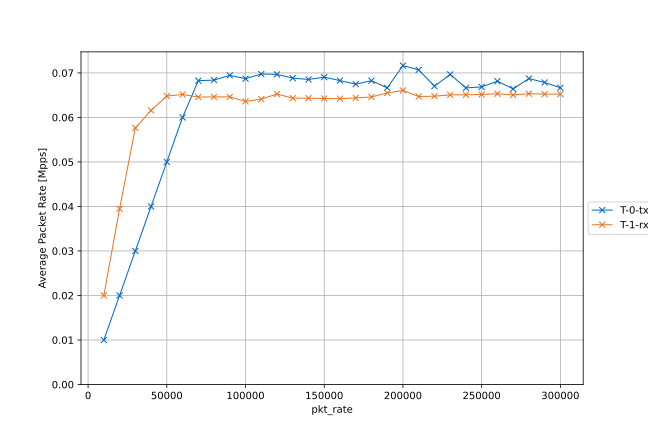

'figures/chameleon_pkt_sz-64_loop_avg_mpps.svg'

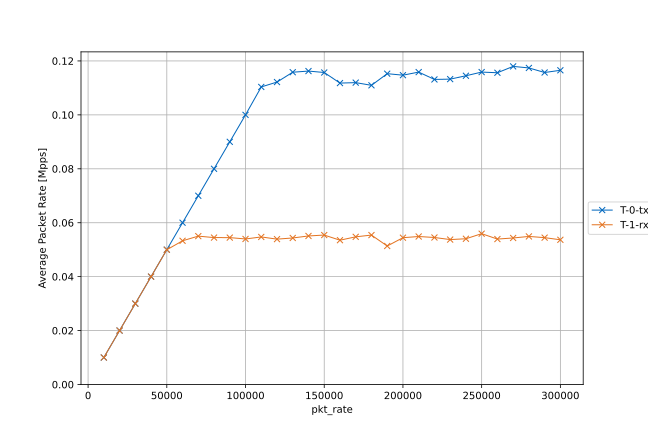

In [25]:
for svg_file in pos.allocations.get_variable(ALLOCATION, "svg_files", from_global=True).get('variable', []):
    svg_content = pos.allocations.get_variable(ALLOCATION, svg_file, from_global=True).get('variable', '')
    IPython.display.display(svg_file)
    IPython.display.display(IPython.display.SVG(svg_content))